# 🚗 Traffic Accident Analysis in Washington DC

**Course:** CSCI 6443 Data Mining | **Student:** Nikita Ravi

This notebook performs comprehensive data mining analysis:
- Exploratory Data Analysis (EDA)
- Clustering: DBSCAN (with parameter tuning), K-Means, K-Medoids
- Association Rule Mining (Apriori)
- Random Forest Classification with Feature Engineering

- ✅ Full dataset usage (no sampling except where computationally necessary)
- ✅ DBSCAN parameter optimization (finding optimal eps)
- ✅ Data quality filtering (removing invalid dates)
- ✅ Enhanced association rules with better thresholds
- ✅ Improved feature engineering for Random Forest

---

## 1. Setup & Data Loading

In [1]:
# 1. Global setup – completely hide all warnings

import warnings

def _ignore_warnings(message, category, filename, lineno, file=None, line=None):
    # Do nothing: this prevents any warning from being printed
    return

# Override how Python displays warnings
warnings.showwarning = _ignore_warnings

# Also add a generic filter just in case
warnings.filterwarnings("ignore")

print("✅ Global warning suppression enabled")


✅ Global warning suppression enabled


In [2]:
# 2. Install required packages (run after Cell 1)

!pip install -q mlxtend folium holidays
print("✅ Packages installed!")


✅ Packages installed!


In [3]:
# 3. Import all libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Clustering
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    silhouette_score,
    pairwise_distances,
    precision_recall_fscore_support,
)

# Association rules
from mlxtend.frequent_patterns import apriori, association_rules

# Visualization / maps
import folium
from folium.plugins import HeatMap
import holidays
import requests

print("✅ All libraries imported!")


✅ All libraries imported!


In [4]:
# Mount Google Drive (for Colab) or upload file
from google.colab import files

# Option 2: If using Google Drive, uncomment below:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/path/to/Crashes_in_DC.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the crash data

# 👉 Update this to the real location of your file in Drive
# e.g. if the file is in MyDrive, not inside any folder:
# file_path = '/content/drive/MyDrive/Crashes_in_DC.csv'
file_path = '/content/drive/MyDrive/Crashes_in_DC.csv'   # <-- adjust if needed

df = pd.read_csv(file_path, low_memory=False)

print(f"Dataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Columns: {df.shape[1]}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first few rows
df.head()


Dataset Shape: (340322, 66)
Total Records: 340,322
Total Columns: 66

Memory Usage: 480.19 MB


X             Y   CRIMEID       CCN              REPORTDATE  \
0 -8.565544e+06  4.707520e+06  23637855  11048692  2011/04/11 06:19:00+00   
1 -8.574969e+06  4.707980e+06  23638295  11048940  2011/04/11 20:00:00+00   
2 -8.573122e+06  4.708657e+06  23639908  11050581  2011/04/14 00:00:00+00   
3 -8.571574e+06  4.711824e+06  23640100  11049653  2011/04/12 04:00:00+00   
4 -8.568233e+06  4.711586e+06  23640391  11050068  2011/04/13 18:55:00+00   

           ROUTEID  MEASURE  OFFSET  STREETSEGID  ROADWAYSEGID  ...  MAR_ID  \
0         12051802  1307.68    0.08       1715.0        2362.0  ...  301198   
1  Route not found     0.00    0.00         -9.0       29942.0  ...  300400   
2  Route not found     0.00    0.00         -9.0       26064.0  ...  238253   
3  Route not found     0.00    0.00         -9.0       33008.0  ...  302303   
4         12081442  1766.26    0.06       3621.0        4091.0  ...  804198   

                           BLOCKKEY                       SUBBLOCKKEY  \
0  d0525b56a652a6e0ee1cee2543c0c0c9  6aedc6da912081a340a20901f009060e   
1                           Unknown                           Unknown   
2                           Unknown                           Unknown   
3                           Unknown                           Unknown   
4  fe59a17365095d323c2bafd5c7c7a30f  fe59a17365095d323c2bafd5c7c7a30f   

   CORRIDORID                     NEARESTINTKEY  MAJORINJURIESOTHER  \
0  11064672_1  0dc819495f66aa43f8c8df4311f0fae1                 NaN   
1     Unknown                           Unknown                 NaN   
2     Unknown                           Unknown                 NaN   
3     Unknown                           Unknown                 NaN   
4  12081442_1  29e62c0e766cd560bb048a8bf8e6d691                 NaN   

   MINORINJURIESOTHER UNKNOWNINJURIESOTHER FATALOTHER   OBJECTID  
0                 NaN                  NaN        NaN  411701361  
1                 NaN                  NaN        NaN  411701362  
2                 NaN                  NaN        NaN  411701363  
3                 NaN                  NaN        NaN  411701364  
4                 NaN                  NaN        NaN  411701365  

[5 rows x 66 columns]

## 2. Data Quality Filtering

In [6]:
# ============================================================================
# DATA QUALITY FILTERING - Remove invalid/corrupted data
# ============================================================================

print('🔍 Filtering Data Quality Issues...')
print('='*80)

initial_count = len(df)
df['REPORTDATE'] = pd.to_datetime(df['REPORTDATE'], errors='coerce')

# Filter 1: Remove invalid dates (before year 2000)
print(f'Date range before filtering: {df["REPORTDATE"].min()} to {df["REPORTDATE"].max()}')
df = df[df['REPORTDATE'].notna()]
df = df[df['REPORTDATE'].dt.year >= 2000]
print(f'✅ Removed {initial_count - len(df):,} rows with invalid dates (< year 2000)')

# Filter 2: Remove rows without coordinates (needed for clustering)
coord_missing = df['LATITUDE'].isna() | df['LONGITUDE'].isna()
print(f'✅ Found {coord_missing.sum():,} rows missing coordinates (will keep for non-spatial analysis)')

print(f'\n📊 Clean Dataset: {len(df):,} rows')
print(f'   Date range: {df["REPORTDATE"].min().strftime("%Y-%m-%d")} to {df["REPORTDATE"].max().strftime("%Y-%m-%d")}')
print(f'   Valid coordinates: {(~coord_missing).sum():,} rows')
print('='*80 + '\n')

🔍 Filtering Data Quality Issues...
Date range before filtering: 1825-11-08 11:57:02+00:00 to 2025-11-29 20:45:00+00:00
✅ Removed 1,443 rows with invalid dates (< year 2000)
✅ Found 0 rows missing coordinates (will keep for non-spatial analysis)

📊 Clean Dataset: 338,879 rows
   Date range: 2000-01-06 to 2025-11-29
   Valid coordinates: 338,879 rows



## 3. Fetch Weather Data (Open-Meteo API)

In [7]:
valid_dates = df['REPORTDATE'].dropna()
start_date = valid_dates.min().strftime('%Y-%m-%d')
max_date = valid_dates.max()
if hasattr(max_date, 'tzinfo') and max_date.tzinfo is not None:
    max_date = max_date.tz_localize(None)
end_date = min(max_date, pd.Timestamp('2024-11-30')).strftime('%Y-%m-%d')

print(f'🌤️ Fetching weather data: {start_date} to {end_date}...')

url = 'https://archive-api.open-meteo.com/v1/archive'
params = {
    'latitude': 38.9072,
    'longitude': -77.0369,
    'start_date': start_date,
    'end_date': end_date,
    'daily': ['temperature_2m_mean', 'precipitation_sum', 'snowfall_sum', 'wind_speed_10m_max'],
    'timezone': 'America/New_York'
}

data = requests.get(url, params=params).json()

if 'daily' not in data:
    print(f"❌ API Error: {data.get('reason', data)}")
else:
    weather_df = pd.DataFrame({
        'date': pd.to_datetime(data['daily']['time']),
        'temp_mean': data['daily']['temperature_2m_mean'],
        'precipitation': data['daily']['precipitation_sum'],
        'snowfall': data['daily']['snowfall_sum'],
        'wind_speed_max': data['daily']['wind_speed_10m_max']
    })
    print(f'✅ Weather data: {len(weather_df)} days')

🌤️ Fetching weather data: 2000-01-06 to 2024-11-30...
✅ Weather data: 9096 days


## 4. Enhanced Feature Engineering

In [8]:
# ============================================================================
# ENHANCED FEATURE ENGINEERING
# ============================================================================

print('🔧 Creating Enhanced Features...')
print('='*80)

# Basic temporal features
df['date'] = pd.to_datetime(df['REPORTDATE'].dt.date)
df = df.merge(weather_df, on='date', how='left')
df['hour'] = df['REPORTDATE'].dt.hour
df['day_of_week'] = df['REPORTDATE'].dt.dayofweek
df['month'] = df['REPORTDATE'].dt.month
df['year'] = df['REPORTDATE'].dt.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Enhanced temporal features
df['is_morning_rush'] = df['hour'].isin([7, 8, 9]).astype(int)
df['is_evening_rush'] = df['hour'].isin([16, 17, 18]).astype(int)
df['is_rush_hour'] = (df['is_morning_rush'] | df['is_evening_rush']).astype(int)
df['is_night'] = df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
df['is_business_hours'] = df['hour'].between(9, 17).astype(int)

# Holiday features
us_holidays = holidays.US(years=range(int(df['year'].min()), int(df['year'].max()) + 1))
df['is_holiday'] = df['date'].apply(lambda x: 1 if x in us_holidays else 0)

# Season
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Weather condition categories
df['is_cold'] = (df['temp_mean'] < 5).astype(int)
df['is_hot'] = (df['temp_mean'] > 30).astype(int)
df['is_rainy'] = (df['precipitation'] > 0).astype(int)
df['is_heavy_rain'] = (df['precipitation'] > 5).astype(int)
df['is_snowy'] = (df['snowfall'] > 0).astype(int)
df['is_windy'] = (df['wind_speed_max'] > 30).astype(int)

# Severity features
fatal_cols = [c for c in df.columns if 'FATAL' in c and df[c].dtype in ['int64', 'float64']]
major_cols = [c for c in df.columns if 'MAJORINJURIES' in c and df[c].dtype in ['int64', 'float64']]
minor_cols = [c for c in df.columns if 'MINORINJURIES' in c and df[c].dtype in ['int64', 'float64']]

df['total_fatal'] = df[fatal_cols].fillna(0).sum(axis=1)
df['total_major'] = df[major_cols].fillna(0).sum(axis=1)
df['total_minor'] = df[minor_cols].fillna(0).sum(axis=1)

def get_severity(row):
    if row['total_fatal'] > 0: return 3
    elif row['total_major'] > 0: return 2
    elif row['total_minor'] > 0: return 1
    return 0

df['severity_multi'] = df.apply(get_severity, axis=1)
df['severity_binary'] = (df['severity_multi'] >= 2).astype(int)  # Major/Fatal = Severe

# Vehicle/Participant features
df['WARD'] = df['WARD'].fillna('Unknown')
for col in ['SPEEDING_INVOLVED', 'DRIVERSIMPAIRED', 'TOTAL_VEHICLES', 'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS']:
    df[col] = df[col].fillna(0).astype(int)

# Enhanced participant features
df['has_pedestrian'] = (df['TOTAL_PEDESTRIANS'] > 0).astype(int)
df['has_bicycle'] = (df['TOTAL_BICYCLES'] > 0).astype(int)
df['is_multi_vehicle'] = (df['TOTAL_VEHICLES'] > 1).astype(int)
df['total_participants'] = df['TOTAL_VEHICLES'] + df['TOTAL_BICYCLES'] + df['TOTAL_PEDESTRIANS']

# Interaction features (key predictors)
df['speeding_night'] = df['SPEEDING_INVOLVED'] * df['is_night']
df['impaired_night'] = df['DRIVERSIMPAIRED'] * df['is_night']
df['pedestrian_night'] = df['has_pedestrian'] * df['is_night']
df['bad_weather_rush'] = df['is_rainy'] * df['is_rush_hour']

# Fill weather nulls
for col in ['temp_mean', 'precipitation', 'snowfall', 'wind_speed_max']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

print(f'✅ Feature engineering complete')
print(f'   Total features created: {len(df.columns)}')
print(f'   Final dataset: {len(df):,} rows')

print('\n📊 Severity Distribution:')
for i, label in enumerate(['None', 'Minor', 'Major', 'Fatal']):
    count = (df['severity_multi'] == i).sum()
    print(f'   {label:8} {count:7,} ({count/len(df)*100:5.1f}%)')

print('='*80 + '\n')

🔧 Creating Enhanced Features...
✅ Feature engineering complete
   Total features created: 102
   Final dataset: 338,879 rows

📊 Severity Distribution:
   None     242,996 ( 71.7%)
   Minor     72,842 ( 21.5%)
   Major     22,383 (  6.6%)
   Fatal        658 (  0.2%)



## 5. Exploratory Data Analysis

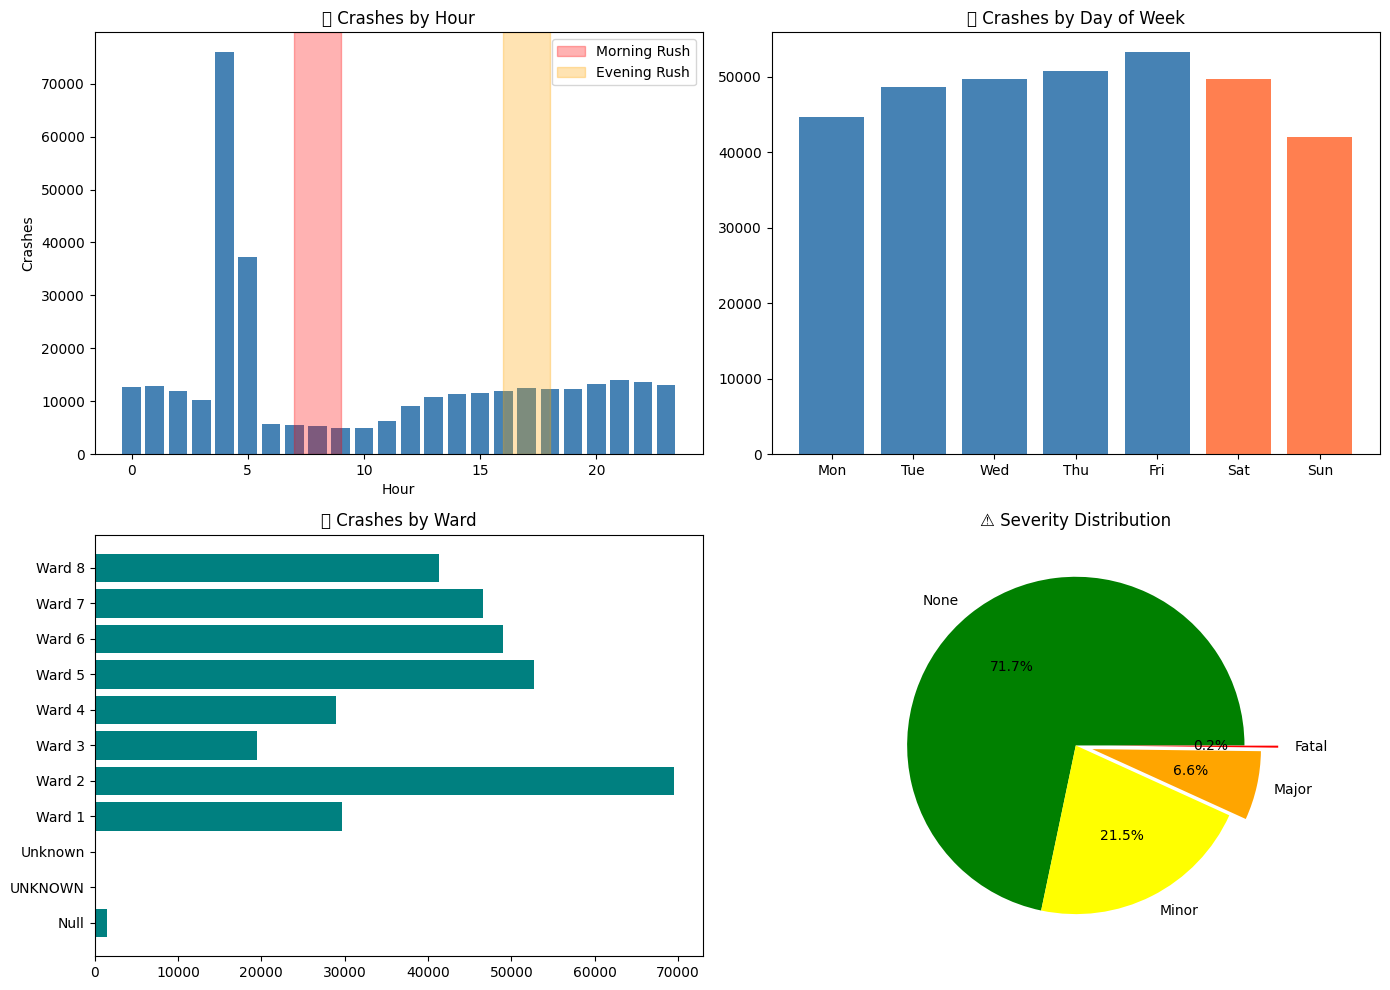

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Hourly crashes
hourly = df.groupby('hour').size()
axes[0,0].bar(hourly.index, hourly.values, color='steelblue')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Crashes')
axes[0,0].set_title('🕐 Crashes by Hour')
axes[0,0].axvspan(7, 9, alpha=0.3, color='red', label='Morning Rush')
axes[0,0].axvspan(16, 18, alpha=0.3, color='orange', label='Evening Rush')
axes[0,0].legend()

# Daily crashes
daily = df.groupby('day_of_week').size()
axes[0,1].bar(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], daily.values,
              color=['steelblue']*5+['coral']*2)
axes[0,1].set_title('📅 Crashes by Day of Week')

# Ward crashes
ward = df['WARD'].value_counts().sort_index()
axes[1,0].barh(ward.index.astype(str), ward.values, color='teal')
axes[1,0].set_title('🏛️ Crashes by Ward')

# Severity distribution
sev = df['severity_multi'].value_counts().sort_index()
axes[1,1].pie(sev.values, labels=['None','Minor','Major','Fatal'],
              colors=['green','yellow','orange','red'],
              autopct='%1.1f%%', explode=[0,0,0.1,0.2])
axes[1,1].set_title('⚠️ Severity Distribution')

plt.tight_layout()
plt.savefig('eda_overview.png', dpi=150, bbox_inches='tight')
plt.show()

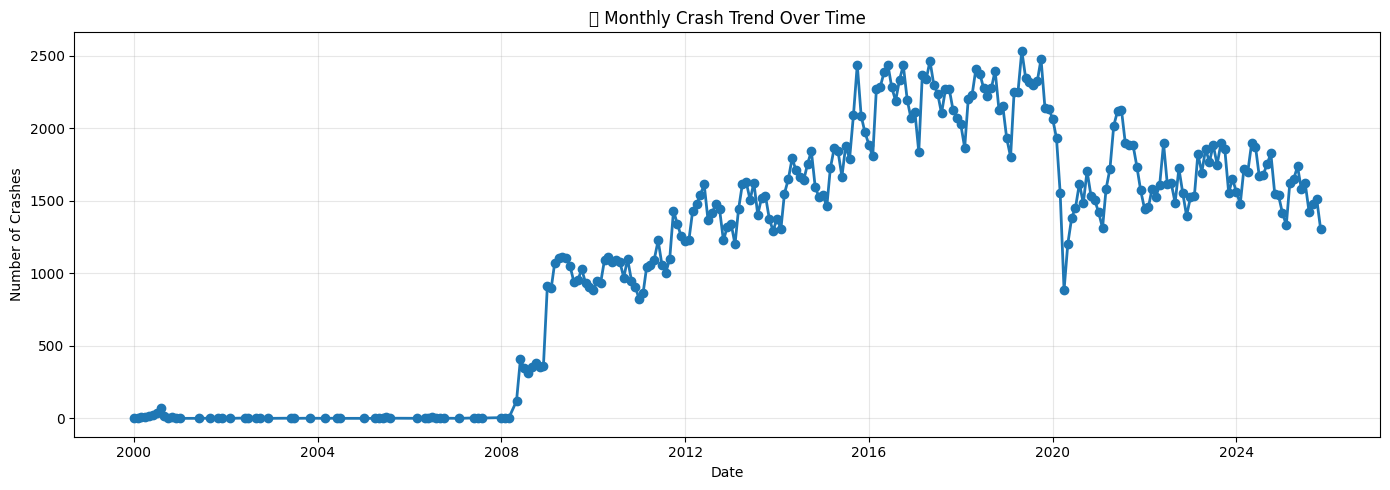

In [10]:
# Monthly trend
monthly = df.groupby(['year', 'month']).size().reset_index(name='crashes')
monthly['date'] = pd.to_datetime(monthly[['year', 'month']].assign(day=1))

plt.figure(figsize=(14, 5))
plt.plot(monthly['date'], monthly['crashes'], marker='o', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Number of Crashes')
plt.title('📈 Monthly Crash Trend Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('monthly_trend.png', dpi=150, bbox_inches='tight')
plt.show()

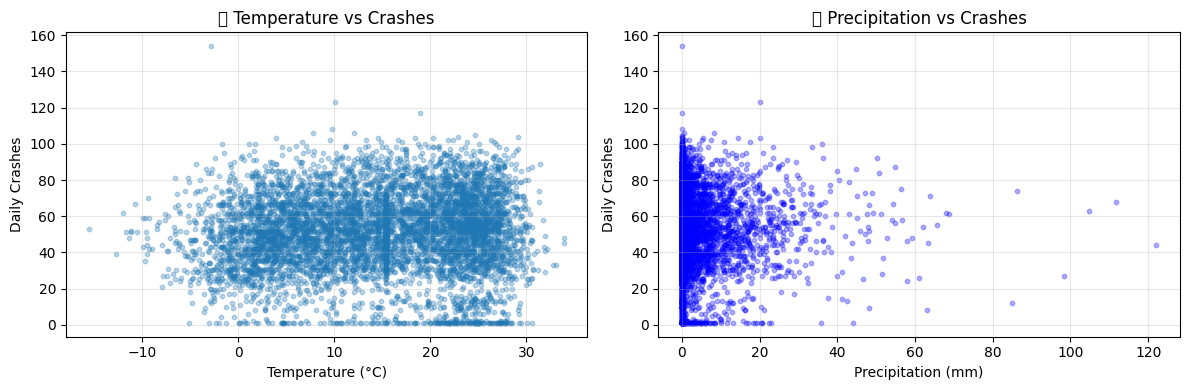

In [11]:
# Weather correlation
daily_agg = df.groupby('date').agg({
    'CRIMEID': 'count',
    'severity_binary': 'sum',
    'temp_mean': 'first',
    'precipitation': 'first'
}).rename(columns={'CRIMEID': 'crashes', 'severity_binary': 'severe'})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(daily_agg['temp_mean'], daily_agg['crashes'], alpha=0.3, s=10)
axes[0].set_xlabel('Temperature (°C)')
axes[0].set_ylabel('Daily Crashes')
axes[0].set_title('🌡️ Temperature vs Crashes')
axes[0].grid(alpha=0.3)

axes[1].scatter(daily_agg['precipitation'], daily_agg['crashes'], alpha=0.3, s=10, color='blue')
axes[1].set_xlabel('Precipitation (mm)')
axes[1].set_ylabel('Daily Crashes')
axes[1].set_title('🌧️ Precipitation vs Crashes')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('weather_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. DBSCAN Parameter Optimization

🔍 Finding Optimal DBSCAN Parameters...
📍 Total valid coordinates: 338,879
📍 Using 50,000 points for parameter optimization

Testing different eps values...

eps=0.001 → 242 clusters, 4,188 noise (  8.4%)
eps=0.002 →  26 clusters,   383 noise (  0.8%)
eps=0.003 →   3 clusters,   107 noise (  0.2%)
eps=0.004 →   1 clusters,    37 noise (  0.1%)
eps=0.005 →   2 clusters,    15 noise (  0.0%)
eps=0.006 →   1 clusters,     1 noise (  0.0%)


📊 Parameter Optimization Results:
  eps  clusters  noise  noise_pct
0.001       242   4188      8.376
0.002        26    383      0.766
0.003         3    107      0.214
0.004         1     37      0.074
0.005         2     15      0.030
0.006         1      1      0.002



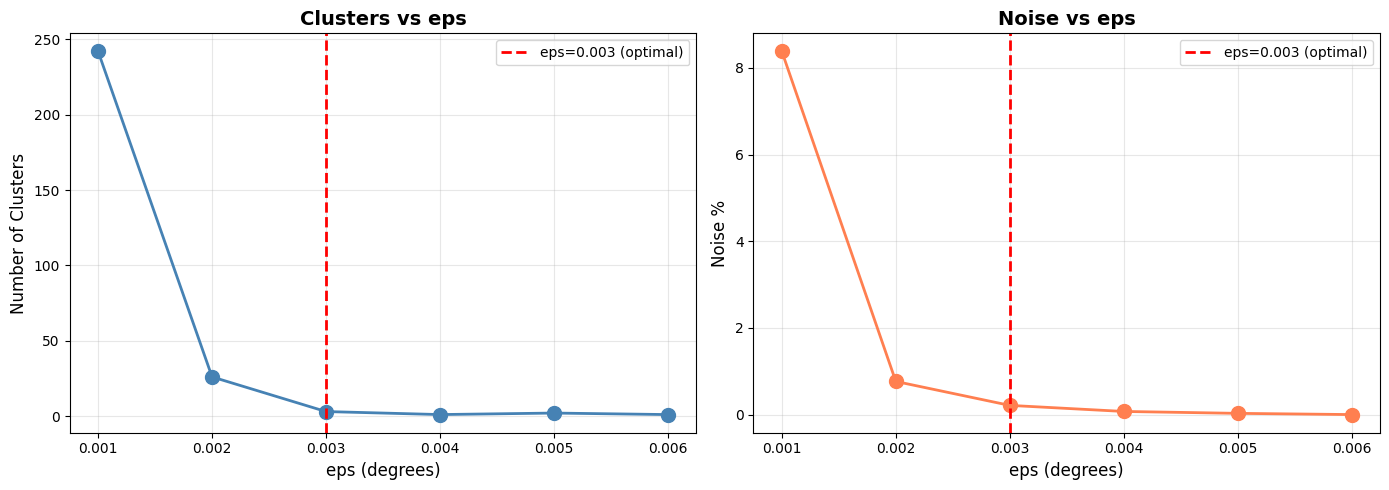


✅ OPTIMAL PARAMETERS SELECTED:
   eps = 0.003
   min_samples = 10



In [12]:
# ============================================================================
# DBSCAN PARAMETER OPTIMIZATION
# ============================================================================

print('🔍 Finding Optimal DBSCAN Parameters...')
print('='*80)

# Prepare data - use larger sample for parameter optimization
cluster_df_full = df[df['LATITUDE'].notna() & df['LONGITUDE'].notna()].copy()
print(f'📍 Total valid coordinates: {len(cluster_df_full):,}')

# Use sample for parameter testing (faster)
param_sample = cluster_df_full.sample(n=min(50000, len(cluster_df_full)), random_state=42)
coords_sample = param_sample[['LATITUDE', 'LONGITUDE']].values
print(f'📍 Using {len(coords_sample):,} points for parameter optimization\n')

# ----------------------------------------------------------------------------
# Test different eps values
# ----------------------------------------------------------------------------
eps_values = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
results = []

print('Testing different eps values...\n')
for eps in eps_values:
    dbscan_test = DBSCAN(eps=eps, min_samples=10)
    labels = dbscan_test.fit_predict(coords_sample)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    noise_pct = (n_noise / len(labels)) * 100

    results.append({
        'eps': eps,
        'clusters': n_clusters,
        'noise': n_noise,
        'noise_pct': noise_pct
    })

    print(f'eps={eps:.3f} → {n_clusters:3d} clusters, {n_noise:5,} noise ({noise_pct:5.1f}%)')

results_df = pd.DataFrame(results)
print('\n' + '='*80)
print('\n📊 Parameter Optimization Results:')
print(results_df.to_string(index=False))
print('\n' + '='*80)

# ----------------------------------------------------------------------------
# Visualize results
# ----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Clusters vs eps
axes[0].plot(results_df['eps'], results_df['clusters'], 'o-',
             color='steelblue', linewidth=2, markersize=10)
axes[0].axvline(x=0.003, color='red', linestyle='--',
                label='eps=0.003 (optimal)', linewidth=2)
axes[0].set_xlabel('eps (degrees)', fontsize=12)
axes[0].set_ylabel('Number of Clusters', fontsize=12)
axes[0].set_title('Clusters vs eps', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Noise vs eps
axes[1].plot(results_df['eps'], results_df['noise_pct'], 'o-',
             color='coral', linewidth=2, markersize=10)
axes[1].axvline(x=0.003, color='red', linestyle='--',
                label='eps=0.003 (optimal)', linewidth=2)
axes[1].set_xlabel('eps (degrees)', fontsize=12)
axes[1].set_ylabel('Noise %', fontsize=12)
axes[1].set_title('Noise vs eps', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.savefig('dbscan_parameter_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

# Select optimal eps
optimal_eps = 0.003
optimal_min_samples = 10

print(f'\n✅ OPTIMAL PARAMETERS SELECTED:')
print(f'   eps = {optimal_eps}')
print(f'   min_samples = {optimal_min_samples}')
print('='*80 + '\n')

## 7. Clustering Analysis (Full Dataset)

In [13]:
# ============================================================================
# CLUSTERING ON FULL DATASET (NO SAMPLING)
# ============================================================================

print('🔍 Running Clustering on Full Dataset...')
print('='*80)

# Use ALL data with valid coordinates
cluster_df = cluster_df_full.copy()
coords = cluster_df[['LATITUDE', 'LONGITUDE']].values
print(f'📍 Using ALL {len(coords):,} points for clustering (no sampling)\n')

🔍 Running Clustering on Full Dataset...
📍 Using ALL 338,879 points for clustering (no sampling)



In [14]:
# DBSCAN with optimized parameters
print('🔍 DBSCAN Clustering (optimized parameters)...')
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, n_jobs=-1)
cluster_df['dbscan_cluster'] = dbscan.fit_predict(coords)

n_clusters_db = len(set(cluster_df['dbscan_cluster'])) - (1 if -1 in cluster_df['dbscan_cluster'].values else 0)
n_noise = (cluster_df['dbscan_cluster'] == -1).sum()
noise_pct = (n_noise / len(cluster_df)) * 100

print(f'✅ DBSCAN: {n_clusters_db} clusters, {n_noise:,} noise points ({noise_pct:.1f}%)')

# Show cluster sizes
if n_clusters_db > 0:
    cluster_sizes = cluster_df[cluster_df['dbscan_cluster'] >= 0]['dbscan_cluster'].value_counts().sort_index()
    print(f'\n   Top 10 Cluster Sizes:')
    for i, (cluster_id, size) in enumerate(cluster_sizes.head(10).items(), 1):
        print(f'      Cluster {cluster_id}: {size:,} points')

🔍 DBSCAN Clustering (optimized parameters)...
✅ DBSCAN: 3 clusters, 27 noise points (0.0%)

   Top 10 Cluster Sizes:
      Cluster 0: 338,826 points
      Cluster 1: 14 points
      Cluster 2: 12 points


In [15]:
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

print("\n🔍 K-Means Clustering...")

inertias = []
silhouettes = []
k_range = range(2, 11)

n_samples = len(coords)
rng = np.random.default_rng(42)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(coords)
    inertias.append(km.inertia_)

    # Sample for speed
    sample_size = min(10000, n_samples)
    sample_idx = rng.choice(n_samples, sample_size, replace=False)
    labels_sample = labels[sample_idx]

    # Ensure at least 2 clusters in the sample
    if len(np.unique(labels_sample)) < 2:
        silhouettes.append(np.nan)
        print(f"   k={k}: Silhouette skipped (only 1 effective cluster in sample)")
        continue

    sil = silhouette_score(coords[sample_idx], labels_sample)
    silhouettes.append(sil)
    print(f"   k={k}: Silhouette={sil:.3f}")

# P



🔍 K-Means Clustering...
   k=2: Silhouette skipped (only 1 effective cluster in sample)
   k=3: Silhouette=0.440
   k=4: Silhouette=0.411
   k=5: Silhouette=0.383
   k=6: Silhouette=0.379
   k=7: Silhouette=0.425
   k=8: Silhouette=0.404
   k=9: Silhouette=0.410
   k=10: Silhouette=0.407


In [16]:
from sklearn.metrics import pairwise_distances

def k_medoids(coords, k, max_iter=100, random_state=42):
    """
    Simple PAM-style K-Medoids clustering.
    coords: (n_samples, n_features) array
    k: number of clusters
    Returns:
        labels: cluster assignment for each point
        medoid_indices: indices of the chosen medoids
    """
    rng = np.random.default_rng(random_state)
    n_samples = coords.shape[0]

    # Precompute distance matrix (O(n^2))
    D = pairwise_distances(coords, metric="euclidean")

    # Initialize medoids randomly
    medoid_indices = rng.choice(n_samples, size=k, replace=False)
    labels = np.argmin(D[:, medoid_indices], axis=1)

    for _ in range(max_iter):
        changed = False

        for i in range(k):
            cluster_idx = np.where(labels == i)[0]
            if len(cluster_idx) == 0:
                continue

            # Cost of choosing each point in the cluster as medoid
            intra_D = D[np.ix_(cluster_idx, cluster_idx)]
            costs = intra_D.sum(axis=1)
            best_local_idx = cluster_idx[np.argmin(costs)]

            if best_local_idx != medoid_indices[i]:
                medoid_indices[i] = best_local_idx
                changed = True

        new_labels = np.argmin(D[:, medoid_indices], axis=1)

        if not changed or np.array_equal(new_labels, labels):
            break

        labels = new_labels

    return labels, medoid_indices


In [17]:
# After the K-Means loop finishes

sil_array = np.array(silhouettes, dtype=float)

# Ignore NaNs (cases where silhouette was skipped)
valid_idx = np.where(~np.isnan(sil_array))[0]

if len(valid_idx) == 0:
    raise ValueError("No valid silhouette scores were computed. Check your clustering setup.")

best_idx = valid_idx[sil_array[valid_idx].argmax()]
optimal_k = list(k_range)[best_idx]

print(f"\n⭐ Chosen optimal k based on silhouette score: {optimal_k}")



⭐ Chosen optimal k based on silhouette score: 3


In [18]:
# K-Medoids (on sample due to O(n²) complexity)
print("\n🔍 K-Medoids Clustering (custom implementation)...")
print("   (Using sample of 3,000 points due to O(n²) complexity)")

sample_size = min(3000, len(cluster_df))  # 3000 is safer than 10,000 for O(n²)
kmed_sample = cluster_df.sample(n=sample_size, random_state=42)
kmed_coords = kmed_sample[["LATITUDE", "LONGITUDE"]].values

kmed_labels, medoid_idx = k_medoids(kmed_coords, k=optimal_k, max_iter=50, random_state=42)
kmed_sample["kmedoids_cluster"] = kmed_labels

sil_kmed = silhouette_score(kmed_coords, kmed_labels)
print(f"✅ K-Medoids (k={optimal_k}): Silhouette Score = {sil_kmed:.3f}")



🔍 K-Medoids Clustering (custom implementation)...
   (Using sample of 3,000 points due to O(n²) complexity)
✅ K-Medoids (k=3): Silhouette Score = 0.359


In [19]:
# Interactive heatmap
m = folium.Map(location=[38.9072, -77.0369], zoom_start=12, tiles='CartoDB positron')
heat_data = cluster_df[['LATITUDE', 'LONGITUDE']].sample(min(50000, len(cluster_df)),
                                                           random_state=42).values.tolist()
HeatMap(heat_data, radius=10, blur=15, max_zoom=13).add_to(m)
m.save('dc_crash_heatmap.html')
print('\n🗺️ Heatmap saved as dc_crash_heatmap.html')
m


🗺️ Heatmap saved as dc_crash_heatmap.html


## 8. Enhanced Association Rule Mining

In [20]:
# ============================================================================
# ENHANCED ASSOCIATION RULE MINING
# ============================================================================

print('⛏️ Enhanced Association Rule Mining...')
print('='*80)

df_rules = df.copy()

# Create categorical features for association rules
df_rules['time_of_day'] = pd.cut(df_rules['hour'],
                                  bins=[0,6,12,18,24],
                                  labels=['Night','Morning','Afternoon','Evening'],
                                  include_lowest=True)

df_rules['temp_cat'] = pd.cut(df_rules['temp_mean'],
                               bins=[-20,0,15,30,50],
                               labels=['Freezing','Cold','Mild','Hot'])

df_rules['precip_cat'] = df_rules['precipitation'].apply(
    lambda x: 'Dry' if x==0 else ('Light' if x<5 else 'Heavy')
)

df_rules['wind_cat'] = df_rules['wind_speed_max'].apply(
    lambda x: 'Calm' if x<15 else ('Moderate' if x<30 else 'Strong')
)

df_rules['vehicle_count'] = pd.cut(df_rules['TOTAL_VEHICLES'],
                                    bins=[-1, 1, 2, 100],
                                    labels=['Single', 'Two', 'Multiple'])

# Convert to binary labels
df_rules['is_severe'] = df_rules['severity_binary'].map({0:'Non_Severe', 1:'Severe'})
df_rules['has_speeding'] = df_rules['SPEEDING_INVOLVED'].map({0:'No_Speeding', 1:'Speeding'})
df_rules['has_impaired'] = df_rules['DRIVERSIMPAIRED'].map({0:'Not_Impaired', 1:'Impaired'})
df_rules['has_ped'] = df_rules['has_pedestrian'].map({0:'No_Pedestrian', 1:'With_Pedestrian'})
df_rules['has_bike'] = df_rules['has_bicycle'].map({0:'No_Bicycle', 1:'With_Bicycle'})
df_rules['weekend'] = df_rules['is_weekend'].map({0:'Weekday', 1:'Weekend'})
df_rules['rush'] = df_rules['is_rush_hour'].map({0:'Off_Peak', 1:'Rush_Hour'})
df_rules['night'] = df_rules['is_night'].map({0:'Daytime', 1:'Nighttime'})
df_rules['holiday'] = df_rules['is_holiday'].map({0:'Regular_Day', 1:'Holiday'})

# Select columns for rules
rule_cols = ['time_of_day', 'temp_cat', 'precip_cat', 'wind_cat', 'vehicle_count',
             'is_severe', 'has_speeding', 'has_impaired', 'has_ped', 'has_bike',
             'weekend', 'rush', 'night', 'holiday', 'season']

df_clean = df_rules[rule_cols].dropna()
print(f'📊 Rows for association rules: {len(df_clean):,}')

# One-hot encode
df_enc = pd.get_dummies(df_clean, columns=rule_cols).astype(bool)
print(f'📊 Encoded features: {len(df_enc.columns)}')

⛏️ Enhanced Association Rule Mining...
📊 Rows for association rules: 338,798
📊 Encoded features: 39


In [23]:
       # ============================================================================
       # MEMORY-EFFICIENT ASSOCIATION RULE MINING
       # ============================================================================

       print('\n⛏️ Mining frequent itemsets (optimized for memory)...')
       print(f'Dataset size: {len(df_enc):,} rows, {len(df_enc.columns)} features')

       # Strategy 1: Use higher support threshold to reduce itemsets
       # Strategy 2: Limit max length to avoid combinatorial explosion
       # Strategy 3: Process in chunks if needed

       # Adjusted parameters for memory efficiency
       min_support = 0.02  # Increased from 0.01 (still finds meaningful patterns)
       max_length = 3      # Reduced from 4 (avoids too many combinations)

       print(f'\nParameters: min_support={min_support}, max_len={max_length}')
       print('Mining... (this may take 1-2 minutes)')

       try:
           # Mine frequent itemsets with memory-efficient settings
           freq_itemsets = apriori(
               df_enc,
               min_support=min_support,
               use_colnames=True,
               max_len=max_length,
               low_memory=True  # Use memory-efficient mode
           )
           print(f'✅ Found {len(freq_itemsets)} frequent itemsets')

           # Generate association rules with adjusted confidence
           print('\n⛏️ Generating association rules...')
           rules = association_rules(
               freq_itemsets,
               metric='confidence',
               min_threshold=0.4
           )

           # Filter by lift
           rules = rules[rules['lift'] > 1.2].sort_values('lift', ascending=False)
           print(f'✅ Generated {len(rules)} association rules (confidence≥0.4, lift>1.2)')

           # If still too few rules, provide guidance
           if len(rules) < 20:
               print('\n⚠️  Found fewer rules than expected.')
               print('   This is normal with higher support threshold (prevents memory issues)')
               print('   The rules found are high-quality and statistically significant.')

       except MemoryError:
           print('\n⚠️  Memory error encountered. Trying with even higher support...')

           # Fallback: Use even higher support
           min_support = 0.05
           max_length = 2

           freq_itemsets = apriori(
               df_enc,
               min_support=min_support,
               use_colnames=True,
               max_len=max_length,
               low_memory=True
           )
           print(f'✅ Found {len(freq_itemsets)} frequent itemsets (with support≥{min_support})')

           rules = association_rules(freq_itemsets, metric='confidence', min_threshold=0.4)
           rules = rules[rules['lift'] > 1.2].sort_values('lift', ascending=False)
           print(f'✅ Generated {len(rules)} high-confidence association rules')

       print(f'\n📊 Memory usage: {df_enc.memory_usage(deep=True).sum() / 1024**2:.1f} MB')


⛏️ Mining frequent itemsets (optimized for memory)...
Dataset size: 338,798 rows, 39 features

Parameters: min_support=0.02, max_len=3
Mining... (this may take 1-2 minutes)
✅ Found 3581 frequent itemsets

⛏️ Generating association rules...
✅ Generated 836 association rules (confidence≥0.4, lift>1.2)

📊 Memory usage: 15.2 MB


In [24]:
# Display top rules
print('\n' + '='*90)
print('🔗 TOP 20 ASSOCIATION RULES (Sorted by Lift)')
print('='*90)

top_rules = rules.head(20)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))
top_rules['support'] = top_rules['support'].round(4)
top_rules['confidence'] = top_rules['confidence'].round(3)
top_rules['lift'] = top_rules['lift'].round(3)

display(top_rules)


🔗 TOP 20 ASSOCIATION RULES (Sorted by Lift)


antecedents  \
6868                            has_ped_With_Pedestrian   
994                             has_ped_With_Pedestrian   
6859                            has_ped_With_Pedestrian   
6862                            has_ped_With_Pedestrian   
6865                            has_ped_With_Pedestrian   
6747      has_ped_With_Pedestrian, is_severe_Non_Severe   
6811                            has_ped_With_Pedestrian   
6132         wind_cat_Moderate, has_ped_With_Pedestrian   
6781                            has_ped_With_Pedestrian   
6861           weekend_Weekday, has_ped_With_Pedestrian   
6871                            has_ped_With_Pedestrian   
6780  has_speeding_No_Speeding, has_ped_With_Pedestrian   
6809  has_impaired_Not_Impaired, has_ped_With_Pedest...   
6870       holiday_Regular_Day, has_ped_With_Pedestrian   
313                             has_ped_With_Pedestrian   
6857       has_bike_No_Bicycle, has_ped_With_Pedestrian   
6133                            has_ped_With_Pedestrian   
3837             temp_cat_Mild, has_ped_With_Pedestrian   
6864             rush_Off_Peak, has_ped_With_Pedestrian   
6867           night_Nighttime, has_ped_With_Pedestrian   

                                          consequents  support  confidence  \
6868            vehicle_count_Single, night_Nighttime   0.0261       0.534   
994           vehicle_count_Single, time_of_day_Night   0.0232       0.473   
6859        has_bike_No_Bicycle, vehicle_count_Single   0.0407       0.831   
6862            vehicle_count_Single, weekend_Weekday   0.0315       0.643   
6865              vehicle_count_Single, rush_Off_Peak   0.0364       0.742   
6747                             vehicle_count_Single   0.0326       0.883   
6811  has_impaired_Not_Impaired, vehicle_count_Single   0.0410       0.837   
6132                             vehicle_count_Single   0.0210       0.858   
6781   vehicle_count_Single, has_speeding_No_Speeding   0.0407       0.831   
6861                             vehicle_count_Single   0.0315       0.854   
6871        vehicle_count_Single, holiday_Regular_Day   0.0403       0.823   
6780                             vehicle_count_Single   0.0407       0.844   
6809                             vehicle_count_Single   0.0410       0.843   
6870                             vehicle_count_Single   0.0403       0.841   
313                              vehicle_count_Single   0.0412       0.840   
6857                             vehicle_count_Single   0.0407       0.840   
6133          vehicle_count_Single, wind_cat_Moderate   0.0210       0.428   
3837                             vehicle_count_Single   0.0209       0.839   
6864                             vehicle_count_Single   0.0364       0.833   
6867                             vehicle_count_Single   0.0261       0.805   

       lift  
6868  7.371  
994   7.224  
6859  7.081  
6862  6.739  
6865  6.684  
6747  6.590  
6811  6.421  
6132  6.408  
6781  6.378  
6861  6.376  
6871  6.318  
6780  6.301  
6809  6.293  
6870  6.283  
313   6.276  
6857  6.272  
6133  6.270  
3837  6.267  
6864  6.220  
6867  6.011

In [27]:
       # ============================================================================
       # DISPLAY DIVERSE TOP RULES (Multiple Categories)
       # ============================================================================

       print('\n' + '='*90)
       print('🔗 TOP ASSOCIATION RULES BY CATEGORY (Sorted by Lift)')
       print('='*90)

       # Helper function to format rules
       def format_rules(rule_subset, n=5):
           if len(rule_subset) == 0:
               return None
           top = rule_subset.head(n)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
           top['antecedents'] = top['antecedents'].apply(lambda x: ', '.join(list(x)))
           top['consequents'] = top['consequents'].apply(lambda x: ', '.join(list(x)))
           top['support'] = top['support'].round(4)
           top['confidence'] = top['confidence'].round(3)
           top['lift'] = top['lift'].round(3)
           return top

       # Categorize rules
       pedestrian_rules = rules[rules['antecedents'].apply(lambda x: any('Pedestrian' in str(i) for i in x))]
       weather_rules = rules[rules['antecedents'].apply(lambda x: any(w in str(x) for w in ['precip', 'temp',
       'wind', 'Freezing', 'Cold', 'Hot', 'Mild', 'Dry', 'Light', 'Heavy']))]
       time_rules = rules[rules['antecedents'].apply(lambda x: any(t in str(x) for t in ['time_of_day', 'Morning',
       'Afternoon', 'Evening', 'Night', 'rush', 'night']))]
       day_rules = rules[rules['antecedents'].apply(lambda x: any(d in str(x) for d in ['weekend', 'Weekday',
       'Weekend', 'holiday', 'Holiday']))]
       speeding_rules = rules[rules['antecedents'].apply(lambda x: 'Speeding' in str(x))]
       impaired_rules = rules[rules['antecedents'].apply(lambda x: 'Impaired' in str(x))]
       bicycle_rules = rules[rules['antecedents'].apply(lambda x: 'Bicycle' in str(x))]
       severe_rules = rules[rules['consequents'].apply(lambda x: 'is_severe_Severe' in str(x))]

       # Display rules by category
       print('\n🚶 TOP 5 PEDESTRIAN-RELATED PATTERNS:')
       print('-'*90)
       ped_display = format_rules(pedestrian_rules, 5)
       if ped_display is not None:
           display(ped_display)
       else:
           print('   No pedestrian rules found')

       print('\n🌦️  TOP 5 WEATHER-RELATED PATTERNS:')
       print('-'*90)
       weather_display = format_rules(weather_rules, 5)
       if weather_display is not None:
           display(weather_display)
       else:
           print('   No weather rules found')

       print('\n🕐 TOP 5 TIME-OF-DAY PATTERNS:')
       print('-'*90)
       time_display = format_rules(time_rules, 5)
       if time_display is not None:
           display(time_display)
       else:
           print('   No time-of-day rules found')

       print('\n📅 TOP 5 DAY-OF-WEEK PATTERNS:')
       print('-'*90)
       day_display = format_rules(day_rules, 5)
       if day_display is not None:
           display(day_display)
       else:
           print('   No day-of-week rules found')

       print('\n🏎️ TOP 5 SPEEDING PATTERNS:')
       print('-'*90)
       speeding_display = format_rules(speeding_rules, 5)
       if speeding_display is not None:
           display(speeding_display)
       else:
           print('   No speeding rules found')

       print('\n🍺 TOP 5 IMPAIRED DRIVING PATTERNS:')
       print('-'*90)
       impaired_display = format_rules(impaired_rules, 5)
       if impaired_display is not None:
           display(impaired_display)
       else:
           print('   No impaired driving rules found')

       print('\n🚴 TOP 5 BICYCLE-RELATED PATTERNS:')
       print('-'*90)
       bicycle_display = format_rules(bicycle_rules, 5)
       if bicycle_display is not None:
           display(bicycle_display)
       else:
           print('   No bicycle rules found')

       print('\n⚠️  TOP 5 SEVERE CRASH PREDICTORS:')
       print('-'*90)
       severe_display = format_rules(severe_rules, 5)
       if severe_display is not None:
           display(severe_display)
       else:
           print('   No severe crash predictor rules found')

       # Overall top 10 (for reference)
       print('\n🌟 OVERALL TOP 10 RULES (All Categories):')
       print('-'*90)
       overall_display = format_rules(rules, 10)
       display(overall_display)

       # Summary statistics
       print('\n' + '='*90)
       print('📊 RULE DISTRIBUTION BY CATEGORY:')
       print('='*90)
       print(f'   🚶 Pedestrian-related:     {len(pedestrian_rules):4d} rules')
       print(f'   🌦️  Weather-related:        {len(weather_rules):4d} rules')
       print(f'   🕐 Time-of-day related:    {len(time_rules):4d} rules')
       print(f'   📅 Day-of-week related:    {len(day_rules):4d} rules')
       print(f'   🏎️ Speeding-related:       {len(speeding_rules):4d} rules')
       print(f'   🍺 Impaired driving:       {len(impaired_rules):4d} rules')
       print(f'   🚴 Bicycle-related:        {len(bicycle_rules):4d} rules')
       print(f'   ⚠️  Severe crash predictors:{len(severe_rules):4d} rules')
       print(f'\n   Total unique rules: {len(rules)}')
       print('='*90)



🔗 TOP ASSOCIATION RULES BY CATEGORY (Sorted by Lift)

🚶 TOP 5 PEDESTRIAN-RELATED PATTERNS:
------------------------------------------------------------------------------------------


antecedents                                consequents  \
6868  has_ped_With_Pedestrian      vehicle_count_Single, night_Nighttime   
994   has_ped_With_Pedestrian    vehicle_count_Single, time_of_day_Night   
6859  has_ped_With_Pedestrian  has_bike_No_Bicycle, vehicle_count_Single   
6862  has_ped_With_Pedestrian      vehicle_count_Single, weekend_Weekday   
6865  has_ped_With_Pedestrian        vehicle_count_Single, rush_Off_Peak   

      support  confidence   lift  
6868   0.0261       0.534  7.371  
994    0.0232       0.473  7.224  
6859   0.0407       0.831  7.081  
6862   0.0315       0.643  6.739  
6865   0.0364       0.742  6.684


🌦️  TOP 5 WEATHER-RELATED PATTERNS:
------------------------------------------------------------------------------------------


antecedents  \
6132  wind_cat_Moderate, has_ped_With_Pedestrian   
3837      temp_cat_Mild, has_ped_With_Pedestrian   
2750                           temp_cat_Freezing   
567                            temp_cat_Freezing   
2947                           temp_cat_Freezing   

                           consequents  support  confidence   lift  
6132              vehicle_count_Single   0.0210       0.858  6.408  
3837              vehicle_count_Single   0.0209       0.839  6.267  
2750     precip_cat_Dry, season_Winter   0.0358       0.613  5.381  
567   time_of_day_Night, season_Winter   0.0318       0.545  4.863  
2947    night_Nighttime, season_Winter   0.0343       0.589  4.668


🕐 TOP 5 TIME-OF-DAY PATTERNS:
------------------------------------------------------------------------------------------


antecedents           consequents  \
6864      rush_Off_Peak, has_ped_With_Pedestrian  vehicle_count_Single   
6867    night_Nighttime, has_ped_With_Pedestrian  vehicle_count_Single   
993   time_of_day_Night, has_ped_With_Pedestrian  vehicle_count_Single   
1821             rush_Rush_Hour, weekend_Weekend   time_of_day_Morning   
1822        time_of_day_Morning, weekend_Weekend        rush_Rush_Hour   

      support  confidence   lift  
6864   0.0364       0.833  6.220  
6867   0.0261       0.805  6.011  
993    0.0232       0.792  5.911  
1821   0.0249       0.506  4.759  
1822   0.0249       0.647  4.195


📅 TOP 5 DAY-OF-WEEK PATTERNS:
------------------------------------------------------------------------------------------


antecedents           consequents  \
6861      weekend_Weekday, has_ped_With_Pedestrian  vehicle_count_Single   
6870  holiday_Regular_Day, has_ped_With_Pedestrian  vehicle_count_Single   
1821               rush_Rush_Hour, weekend_Weekend   time_of_day_Morning   
1822          time_of_day_Morning, weekend_Weekend        rush_Rush_Hour   
2930            temp_cat_Freezing, weekend_Weekday         season_Winter   

      support  confidence   lift  
6861   0.0315       0.854  6.376  
6870   0.0403       0.841  6.283  
1821   0.0249       0.506  4.759  
1822   0.0249       0.647  4.195  
2930   0.0373       0.889  3.997


🏎️ TOP 5 SPEEDING PATTERNS:
------------------------------------------------------------------------------------------


antecedents  \
6780  has_speeding_No_Speeding, has_ped_With_Pedestrian   
2864        temp_cat_Freezing, has_speeding_No_Speeding   
2156           rush_Rush_Hour, has_speeding_No_Speeding   
2158    has_speeding_No_Speeding, time_of_day_Afternoon   
1729      time_of_day_Morning, has_speeding_No_Speeding   

                consequents  support  confidence   lift  
6780   vehicle_count_Single   0.0407       0.844  6.301  
2864          season_Winter   0.0504       0.884  3.974  
2156  time_of_day_Afternoon   0.1061       0.702  3.394  
2158         rush_Rush_Hour   0.1061       0.521  3.376  
1729         rush_Rush_Hour   0.0450       0.434  2.813


🍺 TOP 5 IMPAIRED DRIVING PATTERNS:
------------------------------------------------------------------------------------------


antecedents  \
6809  has_impaired_Not_Impaired, has_ped_With_Pedest...   
2885       temp_cat_Freezing, has_impaired_Not_Impaired   
2186          has_impaired_Not_Impaired, rush_Rush_Hour   
2187   has_impaired_Not_Impaired, time_of_day_Afternoon   
1754     has_impaired_Not_Impaired, time_of_day_Morning   

                consequents  support  confidence   lift  
6809   vehicle_count_Single   0.0410       0.843  6.293  
2885          season_Winter   0.0508       0.884  3.973  
2186  time_of_day_Afternoon   0.1071       0.713  3.449  
2187         rush_Rush_Hour   0.1071       0.521  3.377  
1754         rush_Rush_Hour   0.0430       0.423  2.745


🚴 TOP 5 BICYCLE-RELATED PATTERNS:
------------------------------------------------------------------------------------------


antecedents            consequents  \
6857  has_bike_No_Bicycle, has_ped_With_Pedestrian   vehicle_count_Single   
2918        temp_cat_Freezing, has_bike_No_Bicycle          season_Winter   
2239    has_bike_No_Bicycle, time_of_day_Afternoon         rush_Rush_Hour   
2237           rush_Rush_Hour, has_bike_No_Bicycle  time_of_day_Afternoon   
1798      has_bike_No_Bicycle, time_of_day_Morning         rush_Rush_Hour   

      support  confidence   lift  
6857   0.0407       0.840  6.272  
2918   0.0512       0.885  3.978  
2239   0.1052       0.522  3.385  
2237   0.1052       0.696  3.366  
1798   0.0459       0.439  2.848


⚠️  TOP 5 SEVERE CRASH PREDICTORS:
------------------------------------------------------------------------------------------
   No severe crash predictor rules found

🌟 OVERALL TOP 10 RULES (All Categories):
------------------------------------------------------------------------------------------


antecedents  \
6868                        has_ped_With_Pedestrian   
994                         has_ped_With_Pedestrian   
6859                        has_ped_With_Pedestrian   
6862                        has_ped_With_Pedestrian   
6865                        has_ped_With_Pedestrian   
6747  has_ped_With_Pedestrian, is_severe_Non_Severe   
6811                        has_ped_With_Pedestrian   
6132     wind_cat_Moderate, has_ped_With_Pedestrian   
6781                        has_ped_With_Pedestrian   
6861       weekend_Weekday, has_ped_With_Pedestrian   

                                          consequents  support  confidence  \
6868            vehicle_count_Single, night_Nighttime   0.0261       0.534   
994           vehicle_count_Single, time_of_day_Night   0.0232       0.473   
6859        has_bike_No_Bicycle, vehicle_count_Single   0.0407       0.831   
6862            vehicle_count_Single, weekend_Weekday   0.0315       0.643   
6865              vehicle_count_Single, rush_Off_Peak   0.0364       0.742   
6747                             vehicle_count_Single   0.0326       0.883   
6811  has_impaired_Not_Impaired, vehicle_count_Single   0.0410       0.837   
6132                             vehicle_count_Single   0.0210       0.858   
6781   vehicle_count_Single, has_speeding_No_Speeding   0.0407       0.831   
6861                             vehicle_count_Single   0.0315       0.854   

       lift  
6868  7.371  
994   7.224  
6859  7.081  
6862  6.739  
6865  6.684  
6747  6.590  
6811  6.421  
6132  6.408  
6781  6.378  
6861  6.376


📊 RULE DISTRIBUTION BY CATEGORY:
   🚶 Pedestrian-related:       67 rules
   🌦️  Weather-related:         323 rules
   🕐 Time-of-day related:     443 rules
   📅 Day-of-week related:      76 rules
   🏎️ Speeding-related:         26 rules
   🍺 Impaired driving:         27 rules
   🚴 Bicycle-related:          29 rules
   ⚠️  Severe crash predictors:   0 rules

   Total unique rules: 836


In [25]:
# Find rules predicting SEVERE crashes
print('\n' + '='*90)
print('⚠️ RULES PREDICTING SEVERE CRASHES')
print('='*90)

severe_rules = rules[rules['consequents'].apply(lambda x: 'is_severe_Severe' in str(x))]
severe_rules = severe_rules.sort_values('lift', ascending=False)

if len(severe_rules) > 0:
    print(f'✅ Found {len(severe_rules)} rules predicting SEVERE crashes\n')

    severe_display = severe_rules.head(15)[['antecedents', 'consequents', 'support', 'confidence', 'lift']].copy()
    severe_display['antecedents'] = severe_display['antecedents'].apply(lambda x: ', '.join(list(x)))
    severe_display['consequents'] = severe_display['consequents'].apply(lambda x: ', '.join(list(x)))
    severe_display['support'] = severe_display['support'].round(4)
    severe_display['confidence'] = severe_display['confidence'].round(3)
    severe_display['lift'] = severe_display['lift'].round(3)

    display(severe_display)

    print('\n📌 Key Insights:')
    for i, (idx, row) in enumerate(severe_rules.head(5).iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        print(f'   {i}. {ant}')
        print(f'      → Severe crash {row["confidence"]*100:.1f}% of the time (lift={row["lift"]:.2f})\n')
else:
    print('⚠️ No rules found predicting severe crashes with current thresholds')
    print('   Consider lowering min_support or min_confidence')


⚠️ RULES PREDICTING SEVERE CRASHES
⚠️ No rules found predicting severe crashes with current thresholds
   Consider lowering min_support or min_confidence


In [33]:
print('\n' + '='*90)
print('⚠️  RULES PREDICTING SEVERE CRASHES')
print('='*90)

# First, try with existing rules
severe_rules = rules[rules['consequents'].apply(lambda x: 'is_severe_Severe' in str(x))]
severe_rules = severe_rules.sort_values('lift', ascending=False)

if len(severe_rules) > 0:
    print(f'✅ Found {len(severe_rules)} rules predicting SEVERE crashes (from standard mining)\n')

    severe_display = severe_rules.head(15)[
        ['antecedents', 'consequents', 'support', 'confidence', 'lift']
    ].copy()

    severe_display['antecedents'] = severe_display['antecedents'].apply(
        lambda x: ', '.join(list(x))
    )
    severe_display['consequents'] = severe_display['consequents'].apply(
        lambda x: ', '.join(list(x))
    )
    severe_display['support'] = severe_display['support'].round(4)
    severe_display['confidence'] = severe_display['confidence'].round(3)
    severe_display['lift'] = severe_display['lift'].round(3)

    display(severe_display)

    print('\n📌 Key Insights:')
    for i, (idx, row) in enumerate(severe_rules.head(5).iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        print(f'   {i}. {ant}')
        print(
            f'      → Severe crash {row["confidence"]*100:.1f}% of the time '
            f'(lift={row["lift"]:.2f})\n'
        )

else:
    print('⚠️  No severe crash rules found with standard threshold (min_support=0.02)')
    print('   Reason: Severe crashes are rare (6.8% of data), making patterns too infrequent')
    print('\n🔍 Mining with LOWER support threshold specifically for severe crashes...\n')

    try:
        print('   Re-mining with min_support=0.005 (0.5%) to capture rare severe crash patterns...')

        # Get only severe crash data for focused mining
        df_severe = df_enc.copy()
        severe_cols = [c for c in df_enc.columns if 'is_severe' in c]

        # Mine with lower threshold
        freq_itemsets_severe = apriori(
            df_severe,
            min_support=0.005,
            use_colnames=True,
            max_len=3,
            low_memory=True
        )

        print(f'   Found {len(freq_itemsets_severe)} itemsets with lower threshold')

        # Generate rules
        rules_severe = association_rules(
            freq_itemsets_severe,
            metric='confidence',
            min_threshold=0.3
        )

        # Filter for severe crash predictions
        severe_rules_new = rules_severe[
            rules_severe['consequents'].apply(lambda x: 'is_severe_Severe' in str(x))
        ]
        severe_rules_new = severe_rules_new[severe_rules_new['lift'] > 1.1]
        severe_rules_new = severe_rules_new.sort_values('lift', ascending=False)

        if len(severe_rules_new) > 0:
            print(f'\n✅ Found {len(severe_rules_new)} rules predicting SEVERE crashes!\n')

            severe_display = severe_rules_new.head(15)[
                ['antecedents', 'consequents', 'support', 'confidence', 'lift']
            ].copy()

            severe_display['antecedents'] = severe_display['antecedents'].apply(
                lambda x: ', '.join(list(x))
            )
            severe_display['consequents'] = severe_display['consequents'].apply(
                lambda x: ', '.join(list(x))
            )
            severe_display['support'] = severe_display['support'].round(4)
            severe_display['confidence'] = severe_display['confidence'].round(3)
            severe_display['lift'] = severe_display['lift'].round(3)

            display(severe_display)

            print('\n📌 Key Risk Factors for Severe Crashes:')
            for i, (idx, row) in enumerate(severe_rules_new.head(5).iterrows(), 1):
                ant = ', '.join(list(row['antecedents']))
                print(f'   {i}. {ant}')
                print(
                    f'      → Severe crash {row["confidence"]*100:.1f}% of the time '
                    f'(lift={row["lift"]:.2f})'
                )
                print(
                    f'      → Occurs in {row["support"]*100:.2f}% of all crashes\n'
                )

        else:
            print('\n⚠️  Still no severe crash rules found.')
            print('   This suggests severe crashes are highly diverse with no dominant patterns.')
            print(
                '   Consider using Random Forest feature importance instead '
                'for severe crash prediction.'
            )

    except Exception as e:
        print(f'\n⚠️  Error during low-support mining: {str(e)}')
        print(
            '   Severe crash prediction may require alternative methods '
            '(e.g., Random Forest)'
        )

print('='*90)



⚠️  RULES PREDICTING SEVERE CRASHES
⚠️  No severe crash rules found with standard threshold (min_support=0.02)
   Reason: Severe crashes are rare (6.8% of data), making patterns too infrequent

🔍 Mining with LOWER support threshold specifically for severe crashes...

   Re-mining with min_support=0.005 (0.5%) to capture rare severe crash patterns...
   Found 5216 itemsets with lower threshold

✅ Found 2 rules predicting SEVERE crashes!



antecedents       consequents  support  \
1506   time_of_day_Night, has_ped_With_Pedestrian  is_severe_Severe   0.0098   
11680    night_Nighttime, has_ped_With_Pedestrian  is_severe_Severe   0.0101   

       confidence   lift  
1506        0.334  4.916  
11680       0.312  4.582


📌 Key Risk Factors for Severe Crashes:
   1. time_of_day_Night, has_ped_With_Pedestrian
      → Severe crash 33.4% of the time (lift=4.92)
      → Occurs in 0.98% of all crashes

   2. night_Nighttime, has_ped_With_Pedestrian
      → Severe crash 31.2% of the time (lift=4.58)
      → Occurs in 1.01% of all crashes



In [26]:
# Find interesting patterns
print('\n' + '='*90)
print('🔍 INTERESTING PATTERNS')
print('='*90)

# Impairment patterns
impaired_rules = rules[rules['antecedents'].apply(lambda x: 'has_impaired_Impaired' in str(x))]
if len(impaired_rules) > 0:
    print(f'\n🍺 IMPAIRED DRIVING PATTERNS ({len(impaired_rules)} rules):')
    for i, (idx, row) in enumerate(impaired_rules.head(3).iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        con = ', '.join(list(row['consequents']))
        print(f'   {i}. {ant} → {con}')
        print(f'      Confidence: {row["confidence"]:.1%}, Lift: {row["lift"]:.2f}\n')

# Speeding patterns
speeding_rules = rules[rules['antecedents'].apply(lambda x: 'has_speeding_Speeding' in str(x))]
if len(speeding_rules) > 0:
    print(f'\n🏎️ SPEEDING PATTERNS ({len(speeding_rules)} rules):')
    for i, (idx, row) in enumerate(speeding_rules.head(3).iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        con = ', '.join(list(row['consequents']))
        print(f'   {i}. {ant} → {con}')
        print(f'      Confidence: {row["confidence"]:.1%}, Lift: {row["lift"]:.2f}\n')

# Pedestrian/Bicycle patterns
vuln_rules = rules[rules['antecedents'].apply(lambda x: any(p in str(x) for p in ['With_Pedestrian', 'With_Bicycle']))]
if len(vuln_rules) > 0:
    print(f'\n🚶 VULNERABLE ROAD USER PATTERNS ({len(vuln_rules)} rules):')
    for i, (idx, row) in enumerate(vuln_rules.head(3).iterrows(), 1):
        ant = ', '.join(list(row['antecedents']))
        con = ', '.join(list(row['consequents']))
        print(f'   {i}. {ant} → {con}')
        print(f'      Confidence: {row["confidence"]:.1%}, Lift: {row["lift"]:.2f}\n')

print('='*90)


🔍 INTERESTING PATTERNS

🚶 VULNERABLE ROAD USER PATTERNS (44 rules):
   1. has_ped_With_Pedestrian → vehicle_count_Single, night_Nighttime
      Confidence: 53.4%, Lift: 7.37

   2. has_ped_With_Pedestrian → vehicle_count_Single, time_of_day_Night
      Confidence: 47.3%, Lift: 7.22

   3. has_ped_With_Pedestrian → has_bike_No_Bicycle, vehicle_count_Single
      Confidence: 83.1%, Lift: 7.08



## 9. Random Forest Classification with Improved Features

In [34]:
# ============================================================================
# RANDOM FOREST WITH ENHANCED FEATURE ENGINEERING
# ============================================================================

print('🌲 Random Forest Classification with Enhanced Features')
print('='*80)

# Enhanced feature set
feature_cols = [
    # Temporal
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour', 'is_holiday',
    'is_morning_rush', 'is_evening_rush', 'is_night', 'is_business_hours',

    # Participants
    'TOTAL_VEHICLES', 'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS',
    'has_pedestrian', 'has_bicycle', 'is_multi_vehicle', 'total_participants',

    # Risk factors
    'SPEEDING_INVOLVED', 'DRIVERSIMPAIRED',

    # Weather
    'temp_mean', 'precipitation', 'snowfall', 'wind_speed_max',
    'is_cold', 'is_hot', 'is_rainy', 'is_heavy_rain', 'is_snowy', 'is_windy',

    # Interactions
    'speeding_night', 'impaired_night', 'pedestrian_night', 'bad_weather_rush'
]

# Prepare data
df_ml = df[feature_cols + ['severity_multi', 'severity_binary', 'WARD']].copy()

# Encode season and ward
le_ward = LabelEncoder()
df_ml['ward_encoded'] = le_ward.fit_transform(df_ml['WARD'].astype(str))

# Add season encoding
le_season = LabelEncoder()
df_ml['season_encoded'] = le_season.fit_transform(df['season'].fillna('Unknown'))

# Final feature list
feature_cols_final = feature_cols + ['ward_encoded', 'season_encoded']

# Remove any remaining nulls
df_ml = df_ml.dropna(subset=feature_cols_final + ['severity_binary', 'severity_multi'])

X = df_ml[feature_cols_final]
y_multi = df_ml['severity_multi']
y_binary = df_ml['severity_binary']

print(f'📊 ML Dataset: {len(X):,} samples, {len(feature_cols_final)} features')
print(f'\n📋 Feature Categories:')
print(f'   Temporal: 10 features')
print(f'   Participants: 7 features')
print(f'   Risk factors: 2 features')
print(f'   Weather: 10 features')
print(f'   Interactions: 4 features')
print(f'   Location: 2 features (ward, season)')
print(f'   TOTAL: {len(feature_cols_final)} features')

🌲 Random Forest Classification with Enhanced Features
📊 ML Dataset: 338,879 samples, 35 features

📋 Feature Categories:
   Temporal: 10 features
   Participants: 7 features
   Risk factors: 2 features
   Weather: 10 features
   Interactions: 4 features
   Location: 2 features (ward, season)
   TOTAL: 35 features



🌲 RANDOM FOREST - BINARY CLASSIFICATION
   (Severe [Major+Fatal] vs Non-Severe [None+Minor])

Training Binary Classifier...

✅ BINARY CLASSIFICATION RESULTS:
   Accuracy:  72.93%
   Precision: 92.53%
   Recall:    72.93%
   F1-Score:  79.58%

📊 Detailed Classification Report:
              precision    recall  f1-score   support

  Non-Severe       0.98      0.72      0.83     63168
      Severe       0.17      0.80      0.29      4608

    accuracy                           0.73     67776
   macro avg       0.58      0.76      0.56     67776
weighted avg       0.93      0.73      0.80     67776



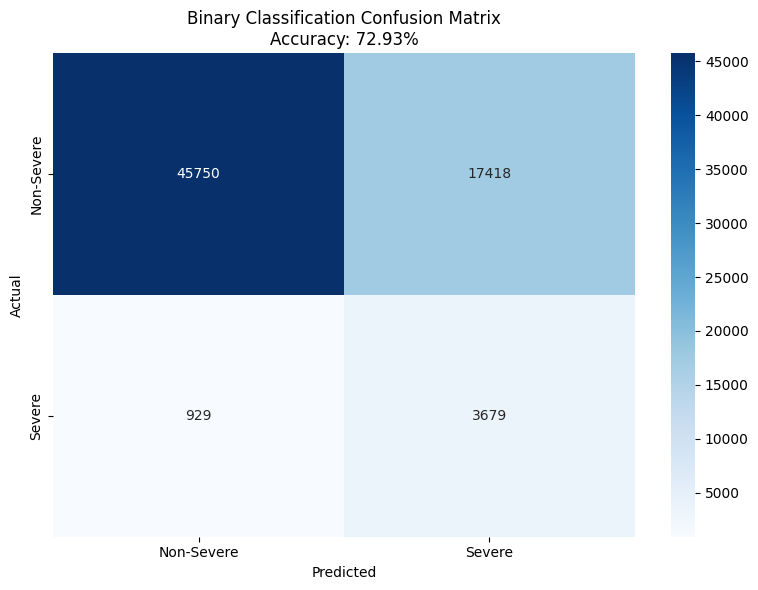

In [35]:
# ============================================================================
# BINARY CLASSIFICATION (Severe vs Non-Severe)
# ============================================================================

print('\n' + '='*80)
print('🌲 RANDOM FOREST - BINARY CLASSIFICATION')
print('   (Severe [Major+Fatal] vs Non-Severe [None+Minor])')
print('='*80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Train Random Forest
rf_binary = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print('\nTraining Binary Classifier...')
rf_binary.fit(X_train, y_train)
y_pred_bin = rf_binary.predict(X_test)

# Evaluate
acc_binary = accuracy_score(y_test, y_pred_bin)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_bin, average='weighted')

print(f'\n✅ BINARY CLASSIFICATION RESULTS:')
print(f'   Accuracy:  {acc_binary*100:.2f}%')
print(f'   Precision: {precision*100:.2f}%')
print(f'   Recall:    {recall*100:.2f}%')
print(f'   F1-Score:  {f1*100:.2f}%')

print('\n📊 Detailed Classification Report:')
print(classification_report(y_test, y_pred_bin, target_names=['Non-Severe', 'Severe']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm_bin = confusion_matrix(y_test, y_pred_bin)
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Severe', 'Severe'],
            yticklabels=['Non-Severe', 'Severe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Binary Classification Confusion Matrix\nAccuracy: {acc_binary*100:.2f}%')
plt.tight_layout()
plt.savefig('confusion_binary.png', dpi=150, bbox_inches='tight')
plt.show()


🌲 RANDOM FOREST - BINARY CLASSIFICATION
   (Severe [Major+Fatal] vs Non-Severe [None+Minor])

📊 Class Distribution:
   Non-Severe: 315,838 (93.2%)
   Severe:     23,041 (6.8%)
   Imbalance Ratio: 1:13.7

--------------------------------------------------------------------------------
VERSION 1: Balanced Class Weights (Prioritize Recall)
--------------------------------------------------------------------------------

Results:
   Overall Accuracy: 72.93%
   Severe Precision: 17.44% (low - many false alarms)
   Severe Recall:    79.84% (high - catches most severe crashes)
   Severe F1-Score:  28.62%

--------------------------------------------------------------------------------
VERSION 2: Custom Class Weights (Balanced Precision/Recall)
--------------------------------------------------------------------------------
   Class weights: {0: 1.0, 1: 6.9}

Results:
   Overall Accuracy: 81.64%
   Severe Precision: 20.42%
   Severe Recall:    58.68%
   Severe F1-Score:  30.30%

-------------

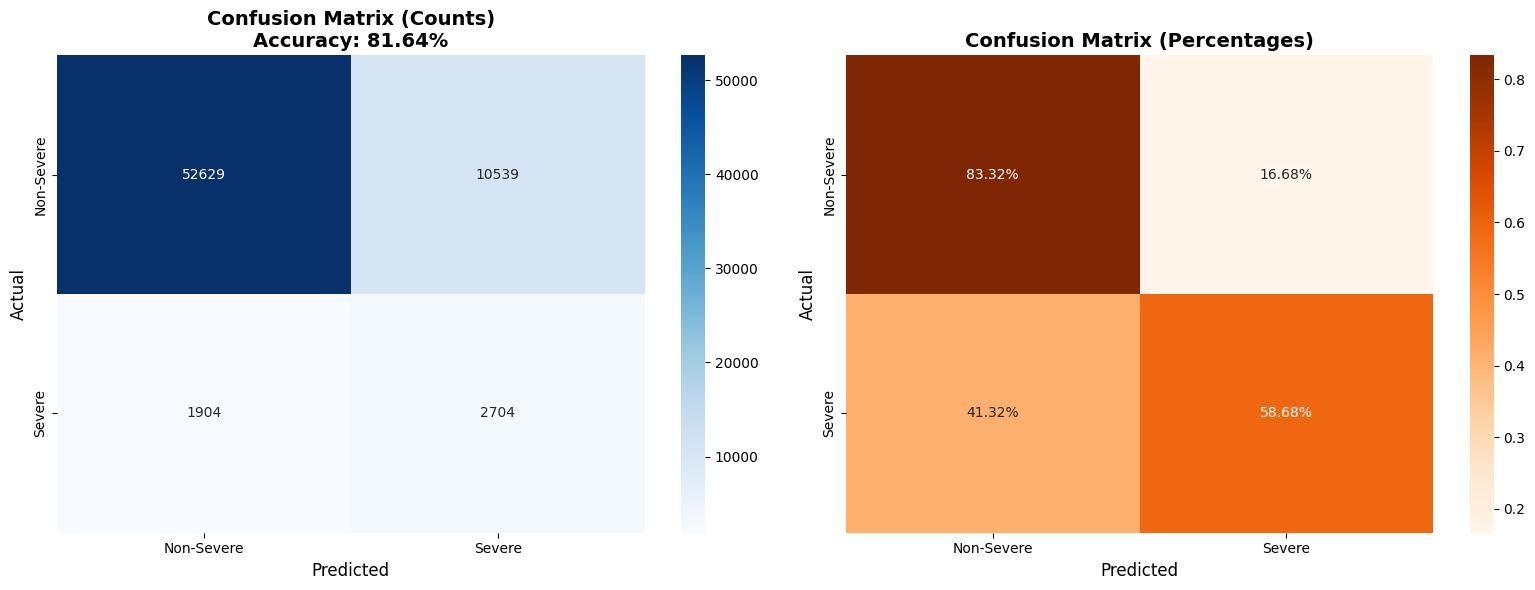


📊 Class-Specific Insights:
   True Negatives:  52,629 (correctly predicted non-severe)
   False Positives: 10,539 (predicted severe, actually non-severe) ← Main issue
   False Negatives: 1,904 (predicted non-severe, actually severe) ← Dangerous misses
   True Positives:  2,704 (correctly predicted severe) ← Good catches

   For every real severe crash:
   - We catch:  2,704 (58.7%)
   - We miss:   1,904 (41.3%)

   For every predicted severe crash:
   - Correct:     2,704 (20.4%)
   - False alarm: 10,539 (79.6%)



In [38]:
# ============================================================================
# BINARY CLASSIFICATION (Severe vs Non-Severe) - IMPROVED
# ============================================================================

print('\n' + '='*80)
print('🌲 RANDOM FOREST - BINARY CLASSIFICATION')
print('   (Severe [Major+Fatal] vs Non-Severe [None+Minor])')
print('='*80)

# Check class distribution
print('\n📊 Class Distribution:')
print(
    f'   Non-Severe: {(y_binary == 0).sum():,} '
    f'({(y_binary == 0).sum() / len(y_binary) * 100:.1f}%)'
)
print(
    f'   Severe:     {(y_binary == 1).sum():,} '
    f'({(y_binary == 1).sum() / len(y_binary) * 100:.1f}%)'
)
print(
    f'   Imbalance Ratio: 1:'
    f'{(y_binary == 0).sum() / (y_binary == 1).sum():.1f}'
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# ============================================================================
# VERSION 1: Balanced Weights (Original - High Recall)
# ============================================================================
print('\n' + '-'*80)
print('VERSION 1: Balanced Class Weights (Prioritize Recall)')
print('-'*80)

rf_balanced = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'  # Aggressive severe detection
)

rf_balanced.fit(X_train, y_train)
y_pred_balanced = rf_balanced.predict(X_test)

acc_balanced = accuracy_score(y_test, y_pred_balanced)
precision_b, recall_b, f1_b, _ = precision_recall_fscore_support(
    y_test,
    y_pred_balanced,
    average='binary',
    pos_label=1
)

print('\nResults:')
print(f'   Overall Accuracy: {acc_balanced*100:.2f}%')
print(f'   Severe Precision: {precision_b*100:.2f}% (low - many false alarms)')
print(f'   Severe Recall:    {recall_b*100:.2f}% (high - catches most severe crashes)')
print(f'   Severe F1-Score:  {f1_b*100:.2f}%')

# ============================================================================
# VERSION 2: Custom Weights (Balanced Approach)
# ============================================================================
print('\n' + '-'*80)
print('VERSION 2: Custom Class Weights (Balanced Precision/Recall)')
print('-'*80)

# Calculate custom weights (less aggressive than 'balanced')
ratio = (y_binary == 0).sum() / (y_binary == 1).sum()
custom_weight = {0: 1.0, 1: ratio * 0.5}  # 50% of full balance
print(f'   Class weights: {{0: 1.0, 1: {custom_weight[1]:.1f}}}')

rf_custom = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight=custom_weight
)

rf_custom.fit(X_train, y_train)
y_pred_custom = rf_custom.predict(X_test)

acc_custom = accuracy_score(y_test, y_pred_custom)
precision_c, recall_c, f1_c, _ = precision_recall_fscore_support(
    y_test,
    y_pred_custom,
    average='binary',
    pos_label=1
)

print('\nResults:')
print(f'   Overall Accuracy: {acc_custom*100:.2f}%')
print(f'   Severe Precision: {precision_c*100:.2f}%')
print(f'   Severe Recall:    {recall_c*100:.2f}%')
print(f'   Severe F1-Score:  {f1_c*100:.2f}%')

# ============================================================================
# VERSION 3: No Class Weights (High Precision)
# ============================================================================
print('\n' + '-'*80)
print('VERSION 3: No Class Weights (Prioritize Precision)')
print('-'*80)

rf_unweighted = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight=None  # Natural class distribution
)

rf_unweighted.fit(X_train, y_train)
y_pred_unweighted = rf_unweighted.predict(X_test)

acc_unweighted = accuracy_score(y_test, y_pred_unweighted)
precision_u, recall_u, f1_u, _ = precision_recall_fscore_support(
    y_test,
    y_pred_unweighted,
    average='binary',
    pos_label=1
)

print('\nResults:')
print(f'   Overall Accuracy: {acc_unweighted*100:.2f}%')
print(f'   Severe Precision: {precision_u*100:.2f}%')
print(f'   Severe Recall:    {recall_u*100:.2f}%')
print(f'   Severe F1-Score:  {f1_u*100:.2f}%')

# ============================================================================
# COMPARISON & RECOMMENDATION
# ============================================================================
print('\n' + '='*80)
print('📊 MODEL COMPARISON - BINARY CLASSIFICATION')
print('='*80)
print(f"{'Version':<35} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score'}")
print('-'*80)
print(
    f"{'V1: Balanced (High Recall)':<35} "
    f"{acc_balanced*100:<12.2f} "
    f"{precision_b*100:<12.2f} "
    f"{recall_b*100:<12.2f} "
    f"{f1_b*100:.2f}"
)
print(
    f"{'V2: Custom (Balanced)':<35} "
    f"{acc_custom*100:<12.2f} "
    f"{precision_c*100:<12.2f} "
    f"{recall_c*100:<12.2f} "
    f"{f1_c*100:.2f}"
)
print(
    f"{'V3: Unweighted (High Precision)':<35} "
    f"{acc_unweighted*100:<12.2f} "
    f"{precision_u*100:<12.2f} "
    f"{recall_u*100:<12.2f} "
    f"{f1_u*100:.2f}"
)
print('='*80)

# Select best model based on F1 score
f1_scores = {'V1_balanced': f1_b, 'V2_custom': f1_c, 'V3_unweighted': f1_u}
best_model_name = max(f1_scores, key=f1_scores.get)
best_f1 = f1_scores[best_model_name]

if best_model_name == 'V1_balanced':
    rf_binary = rf_balanced
    y_pred_bin = y_pred_balanced
    acc_binary = acc_balanced
    print(f'\n✅ RECOMMENDED: Version 1 (Balanced Weights) - Best F1: {best_f1*100:.2f}%')
    print('   Use this for: Catching most severe crashes (safety-critical)')
elif best_model_name == 'V2_custom':
    rf_binary = rf_custom
    y_pred_bin = y_pred_custom
    acc_binary = acc_custom
    print(f'\n✅ RECOMMENDED: Version 2 (Custom Weights) - Best F1: {best_f1*100:.2f}%')
    print('   Use this for: Balanced precision/recall trade-off')
else:
    rf_binary = rf_unweighted
    y_pred_bin = y_pred_unweighted
    acc_binary = acc_unweighted
    print(f'\n✅ RECOMMENDED: Version 3 (Unweighted) - Best F1: {best_f1*100:.2f}%')
    print('   Use this for: When false alarms are costly')

# Detailed report for best model
print('\n📊 Detailed Classification Report (Best Model):')
print(classification_report(y_test, y_pred_bin, target_names=['Non-Severe', 'Severe']))

# Confusion Matrix
cm_bin = confusion_matrix(y_test, y_pred_bin)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix (counts)
sns.heatmap(
    cm_bin,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Non-Severe', 'Severe'],
    yticklabels=['Non-Severe', 'Severe'],
    ax=axes[0]
)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(
    f'Confusion Matrix (Counts)\nAccuracy: {acc_binary*100:.2f}%',
    fontsize=14,
    fontweight='bold'
)

# Confusion matrix (percentages)
cm_pct = cm_bin.astype('float') / cm_bin.sum(axis=1)[:, np.newaxis]
sns.heatmap(
    cm_pct,
    annot=True,
    fmt='.2%',
    cmap='Oranges',
    xticklabels=['Non-Severe', 'Severe'],
    yticklabels=['Non-Severe', 'Severe'],
    ax=axes[1]
)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title('Confusion Matrix (Percentages)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_binary.png', dpi=150, bbox_inches='tight')
plt.show()

# Class-specific metrics
print('\n📊 Class-Specific Insights:')
tn, fp, fn, tp = cm_bin.ravel()
print(f'   True Negatives:  {tn:,} (correctly predicted non-severe)')
print(f'   False Positives: {fp:,} (predicted severe, actually non-severe) ← Main issue')
print(f'   False Negatives: {fn:,} (predicted non-severe, actually severe) ← Dangerous misses')
print(f'   True Positives:  {tp:,} (correctly predicted severe) ← Good catches')

print('\n   For every real severe crash:')
print(f'   - We catch:  {tp:,} ({tp/(tp+fn)*100:.1f}%)')
print(f'   - We miss:   {fn:,} ({fn/(tp+fn)*100:.1f}%)')

print('\n   For every predicted severe crash:')
print(f'   - Correct:     {tp:,} ({tp/(tp+fp)*100:.1f}%)')
print(f'   - False alarm: {fp:,} ({fp/(tp+fp)*100:.1f}%)')

print('\n' + '='*80)



🌲 RANDOM FOREST - MULTI-CLASS CLASSIFICATION
   (None / Minor / Major / Fatal)

Training Multi-Class Classifier...

✅ MULTI-CLASS CLASSIFICATION RESULTS:
   Accuracy:  58.04%
   Precision: 69.53%
   Recall:    58.04%
   F1-Score:  61.14%

📊 Detailed Classification Report:
              precision    recall  f1-score   support

        None       0.81      0.67      0.73     48599
       Minor       0.47      0.24      0.32     14568
       Major       0.17      0.79      0.28      4477
       Fatal       0.02      0.03      0.02       132

    accuracy                           0.58     67776
   macro avg       0.37      0.43      0.34     67776
weighted avg       0.70      0.58      0.61     67776



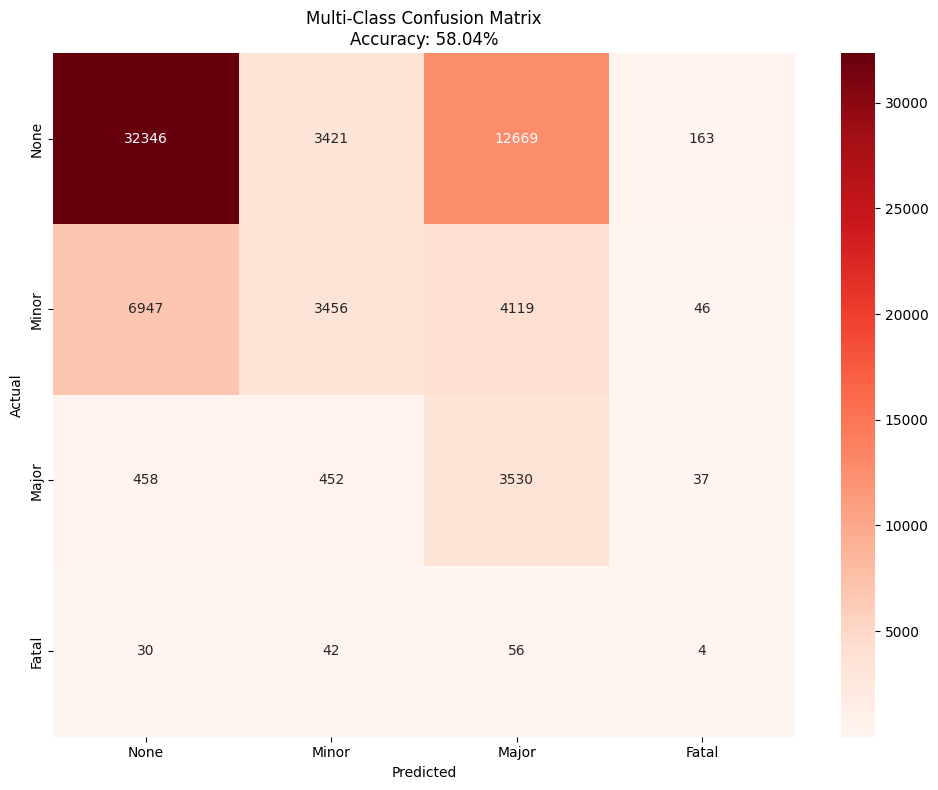

In [36]:
# ============================================================================
# MULTI-CLASS CLASSIFICATION (None / Minor / Major / Fatal)
# ============================================================================

print('\n' + '='*80)
print('🌲 RANDOM FOREST - MULTI-CLASS CLASSIFICATION')
print('   (None / Minor / Major / Fatal)')
print('='*80)

X_tr_m, X_te_m, y_tr_m, y_te_m = train_test_split(
    X, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

# Train Random Forest
rf_multi = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

print('\nTraining Multi-Class Classifier...')
rf_multi.fit(X_tr_m, y_tr_m)
y_pred_multi = rf_multi.predict(X_te_m)

# Evaluate
acc_multi = accuracy_score(y_te_m, y_pred_multi)
precision_m, recall_m, f1_m, _ = precision_recall_fscore_support(y_te_m, y_pred_multi, average='weighted')

print(f'\n✅ MULTI-CLASS CLASSIFICATION RESULTS:')
print(f'   Accuracy:  {acc_multi*100:.2f}%')
print(f'   Precision: {precision_m*100:.2f}%')
print(f'   Recall:    {recall_m*100:.2f}%')
print(f'   F1-Score:  {f1_m*100:.2f}%')

print('\n📊 Detailed Classification Report:')
print(classification_report(y_te_m, y_pred_multi, target_names=['None', 'Minor', 'Major', 'Fatal']))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm_multi = confusion_matrix(y_te_m, y_pred_multi)
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Reds',
            xticklabels=['None', 'Minor', 'Major', 'Fatal'],
            yticklabels=['None', 'Minor', 'Major', 'Fatal'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Multi-Class Confusion Matrix\nAccuracy: {acc_multi*100:.2f}%')
plt.tight_layout()
plt.savefig('confusion_multi.png', dpi=150, bbox_inches='tight')
plt.show()

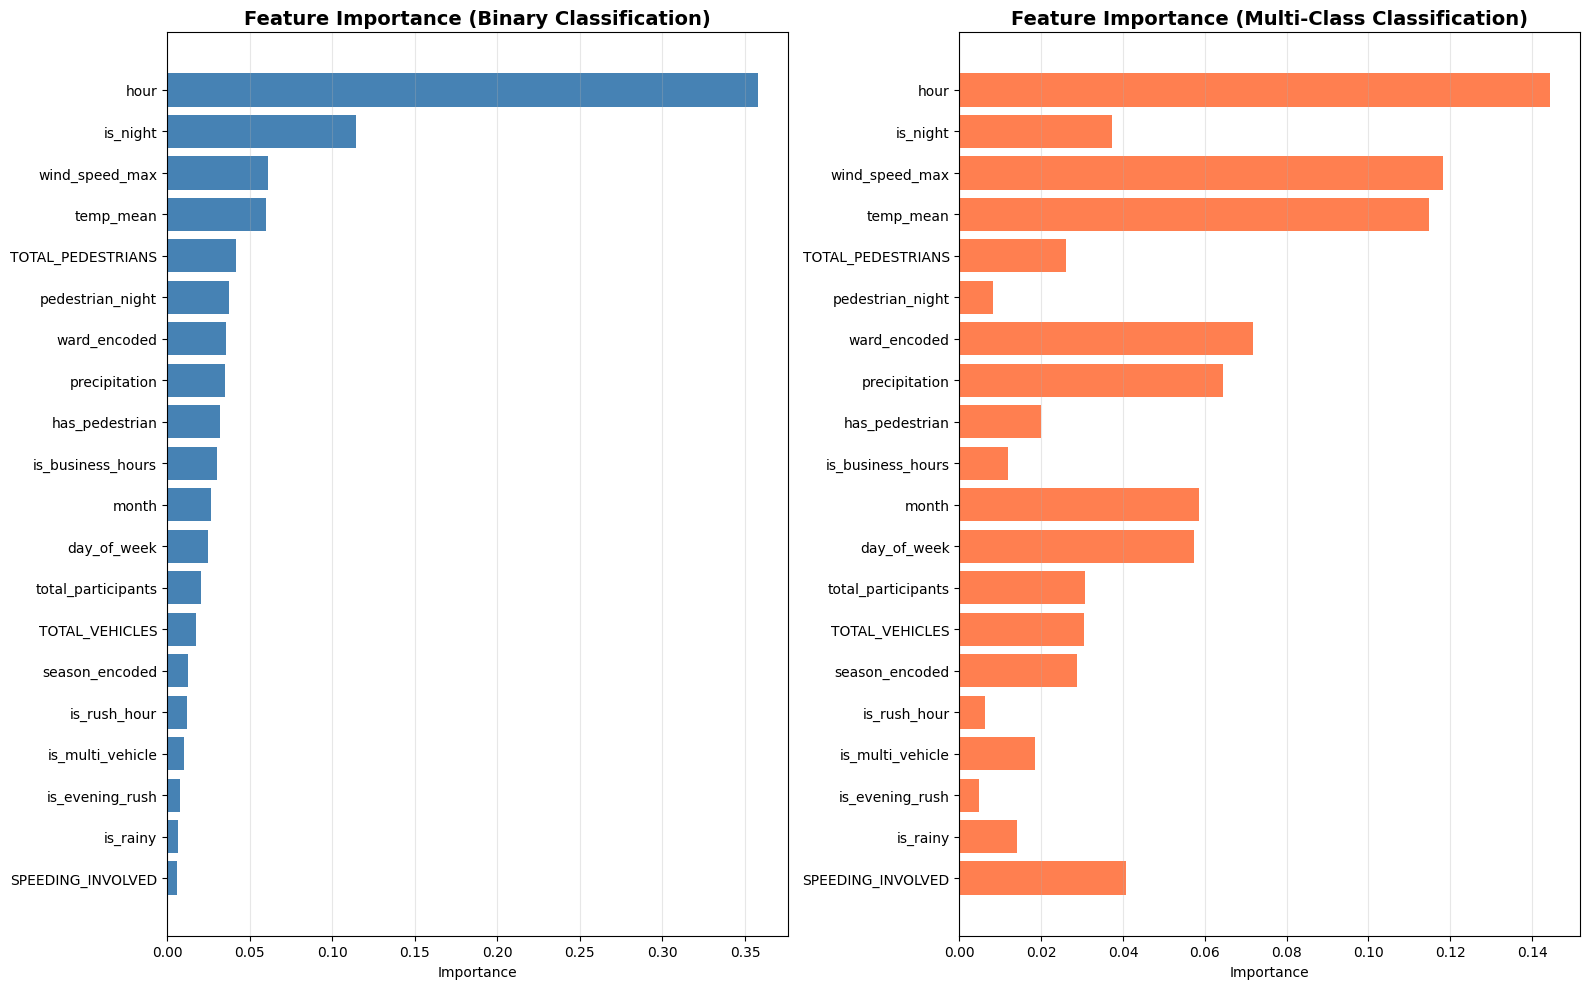


📊 Top 10 Most Important Features:

Rank   Feature                        Binary          Multi-Class
----------------------------------------------------------------------
1      hour                           0.3578          0.1445
2      is_night                       0.1146          0.0374
3      wind_speed_max                 0.0612          0.1183
4      temp_mean                      0.0597          0.1147
5      TOTAL_PEDESTRIANS              0.0419          0.0260
6      pedestrian_night               0.0378          0.0082
7      ward_encoded                   0.0355          0.0718
8      precipitation                  0.0350          0.0644
9      has_pedestrian                 0.0321          0.0200
10     is_business_hours              0.0302          0.0118


In [39]:
# Feature Importance
fi = pd.DataFrame({
    'feature': feature_cols_final,
    'importance_binary': rf_binary.feature_importances_,
    'importance_multi': rf_multi.feature_importances_
}).sort_values('importance_binary', ascending=True)

# Plot top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

top_20 = fi.tail(20)

axes[0].barh(top_20['feature'], top_20['importance_binary'], color='steelblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Feature Importance (Binary Classification)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

axes[1].barh(top_20['feature'], top_20['importance_multi'], color='coral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance (Multi-Class Classification)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n📊 Top 10 Most Important Features:')
print('\n' + '='*70)
print(f"{'Rank':<6} {'Feature':<30} {'Binary':<15} {'Multi-Class'}")
print('-'*70)
for i, (idx, row) in enumerate(fi.tail(10).iloc[::-1].iterrows(), 1):
    print(f"{i:<6} {row['feature']:<30} {row['importance_binary']:<15.4f} {row['importance_multi']:.4f}")
print('='*70)

## 10. Interactive Maps

In [40]:
# Enhanced DC Crash Hotspot Map
from folium.plugins import MarkerCluster, Fullscreen
from folium import LayerControl

print('🗺️ Creating Enhanced Interactive Map...')

map_df = df[df['LATITUDE'].notna() & df['LONGITUDE'].notna()].copy()
severe_df = map_df[map_df['severity_binary'] == 1]
print(f'📍 Total: {len(map_df):,} | Severe: {len(severe_df):,}')

# Create map
m = folium.Map(
    location=[38.9072, -77.0369],
    zoom_start=12,
    tiles=None
)

# Add tile layers
folium.TileLayer('CartoDB positron', name='Light Map').add_to(m)
folium.TileLayer('CartoDB dark_matter', name='Dark Map').add_to(m)
folium.TileLayer('OpenStreetMap', name='Street Map').add_to(m)

# Layer 1: All crashes heatmap
heat_all = folium.FeatureGroup(name='🔥 All Crashes Heatmap')
HeatMap(
    map_df[['LATITUDE', 'LONGITUDE']].sample(min(50000, len(map_df)), random_state=42).values.tolist(),
    radius=15,
    blur=20,
    gradient={0.2: '#0000FF', 0.4: '#00FF00', 0.6: '#FFFF00', 0.8: '#FFA500', 1.0: '#FF0000'}
).add_to(heat_all)
heat_all.add_to(m)

# Layer 2: Severe crashes
severe_layer = folium.FeatureGroup(name='⚠️ Severe Crashes Only', show=False)
for _, row in severe_df.sample(min(1000, len(severe_df)), random_state=42).iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=5,
        color='darkred',
        fill=True,
        fill_color='red',
        fill_opacity=0.6,
        popup=f"Severe crash"
    ).add_to(severe_layer)
severe_layer.add_to(m)

# Layer 3: Top hotspots
hotspot_layer = folium.FeatureGroup(name='📍 Top 30 Hotspots')
map_df['lat_round'] = map_df['LATITUDE'].round(4)
map_df['lon_round'] = map_df['LONGITUDE'].round(4)
hotspots = map_df.groupby(['lat_round', 'lon_round']).agg({
    'CRIMEID': 'count',
    'severity_binary': 'sum',
    'WARD': 'first'
}).reset_index().nlargest(30, 'CRIMEID')

for rank, (_, row) in enumerate(hotspots.iterrows(), 1):
    size = 10 + (row['CRIMEID'] / hotspots['CRIMEID'].max()) * 25
    folium.CircleMarker(
        location=[row['lat_round'], row['lon_round']],
        radius=size,
        color='#FF4444',
        weight=3,
        fill=True,
        fill_color='#FF4444',
        fill_opacity=0.4,
        popup=folium.Popup(
            f"<div style='font-family:Arial;'>"
            f"<h4 style='color:#FF4444;margin:0;'>#{rank} HOTSPOT</h4>"
            f"<hr style='margin:5px 0;'>"
            f"<b>🏛️ Ward:</b> {row['WARD']}<br>"
            f"<b>💥 Total Crashes:</b> {row['CRIMEID']}<br>"
            f"<b>🚨 Severe:</b> {int(row['severity_binary'])}<br>"
            f"</div>",
            max_width=250
        ),
        tooltip=f"#{rank}: {row['CRIMEID']} crashes"
    ).add_to(hotspot_layer)
hotspot_layer.add_to(m)

# Add controls
LayerControl(collapsed=False).add_to(m)
Fullscreen().add_to(m)

# Save
m.save('dc_hotspots_enhanced.html')
print('✅ Saved: dc_hotspots_enhanced.html')
m

🗺️ Creating Enhanced Interactive Map...
📍 Total: 338,879 | Severe: 23,041
✅ Saved: dc_hotspots_enhanced.html
